In [2]:
import pandas as pd
import zipfile
import os
os.chdir('../')

In [3]:
%pwd

'c:\\Users\\Dell\\Documents\\GitHub\\Fake-News-Detection-Model'

In [6]:
zipfile_path = 'data/raw_data.zip'
with zipfile.ZipFile(zipfile_path, 'r') as zip:
    zip.extractall('data/raw_data')

csv = 'data/raw_data/raw_data.csv'

df = pd.read_csv(csv)

: 

In [7]:
df.head()

text  label
0  WASHINGTON (Reuters) - The head of a conservat...      1
1  WASHINGTON (Reuters) - Transgender people will...      1
2  WASHINGTON (Reuters) - The special counsel inv...      1
3  WASHINGTON (Reuters) - Trump campaign adviser ...      1
4  SEATTLE/WASHINGTON (Reuters) - President Donal...      1

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44689 entries, 0 to 44688
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    44689 non-null  object
 1   label   44689 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 698.4+ KB


In [9]:
def check_data(df):
    print('Missing values:\n', df.isnull().sum())
    print('Duplicated rows', df.duplicated().sum())
    df.drop_duplicates(inplace=True)
    df.info()

check_data(df)


Missing values:
 text     0
label    0
dtype: int64
Duplicated rows 6042
<class 'pandas.core.frame.DataFrame'>
Index: 38647 entries, 0 to 43910
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    38647 non-null  object
 1   label   38647 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 905.8+ KB


<Axes: ylabel='count'>

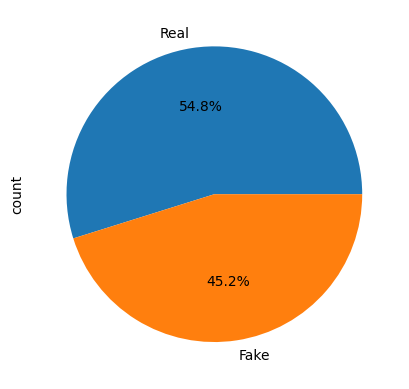

In [10]:
df['label'].value_counts().plot.pie(autopct='%1.1f%%', labels=['Real', 'Fake'])

In [11]:
df['text'][0]

'WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of the national debt to pay for tax cuts, called himself a “fiscal conservative” on Sunday and urged budget restraint in 2018. In keeping with a sharp pivot under way among Republicans, U.S. Representative Mark Meadows, speaking on CBS’ “Face the Nation,” drew a hard line on federal spending, which lawmakers are bracing to do battle over in January. When they return from the holidays on Wednesday, lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues, such as immigration policy, even as the November congressional election campaigns approach in which Republicans will seek to keep control of Congress. President Donald Trump and his Republicans want a big budget increase in military spending, while Democrats also want proportional increases for non-defense “discretionary” spending on programs that support educat

 Here I've cleaned the data before converting into a csv file.

In [13]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

def clean_text(text):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()

    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    
    return text


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [14]:
example_text = "Here is an example! Check this out: https://example.com <b>HTML Content</b>"
cleaned_text = clean_text(example_text)
print(cleaned_text)

example check html content


In [15]:
df['text'] = df['text'].apply(clean_text)
df.head()

text  label
0  washington reuters head conservative republica...      1
1  washington reuters transgender people allowed ...      1
2  washington reuters special counsel investigati...      1
3  washington reuters trump campaign adviser geor...      1
4  seattlewashington reuters president donald tru...      1

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=5000)

tfidf_features = vectorizer.fit_transform(df['text'])
print(tfidf_features.shape)

(38647, 5000)


Here I'll test different models which work good I'll use this in my automation process!

In [17]:
from sklearn.model_selection import train_test_split
X = tfidf_features
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(30917, 5000) (7730, 5000) (30917,) (7730,)


Lets start with logistic Regression

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 98.67%
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      3486
           1       0.98      0.99      0.99      4244

    accuracy                           0.99      7730
   macro avg       0.99      0.99      0.99      7730
weighted avg       0.99      0.99      0.99      7730

Confusion Matrix:
[[3420   66]
 [  37 4207]]


The model performed exceptionally well! That's great news, but we'll further test its capabilities by manually inputting news headlines to see if it can accurately classify them.

In [20]:
def predict_news(headline):
    clean_headline = clean_text(headline)
    features = vectorizer.transform([clean_headline])
    pred = model.predict(features)
    
    # Return whether it's real or fake
    return 'Real' if pred[0] == 1 else 'Fake'

real = predict_news("Global Markets Rally as Central Banks Signal Willingness to Support Economic Growth Amid Uncertainty")
print(f"Prediction for real news headline: {real}")

fake = predict_news("Scientists Confirm First Successful Time Travel Experiment, Man Sent Back to 1967")
print(f"Prediction for fake news headline: {fake}")


Prediction for real news headline: Real
Prediction for fake news headline: Fake
